In [1]:
import os
import cv2
import time
from metrics import shannon_entropy
import nibabel as nib
import tensorflow as tf
import numpy as np
from parameters import TRAIN_PATH, TEST_PATH, BUFFER_SIZE_TRAIN, BUFFER_SIZE_TEST, BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, CODES


def dataset_lookup_table_init(train_path, test_path):
    train_patients = sorted(os.listdir(train_path))
    test_patients = sorted(os.listdir(test_path))
    patients_list = train_patients + test_patients
    patients_list.remove('.DS_Store')

    train_dataset_lookup = {}
    test_dataset_lookup = {}

    count = 1
    for idx in range(len(train_patients)):
        if train_patients[idx] == '.DS_Store':
            continue
        train_dataset_lookup[count] = train_patients[idx]
        count += 1

    for idx in range(len(test_patients)):
        if test_patients[idx] == '.DS_Store':
            continue
        test_dataset_lookup[count] = test_patients[idx]
        count += 1

    return train_dataset_lookup, test_dataset_lookup


def load(idx, train_dataset, test_dataset, train_path, test_path, code="all"):
    # Check if patient is in train or test dataset
    if idx <= 359 and idx > 0:
        patient_code = train_dataset[idx]
        path = os.path.join(train_path, patient_code)
    elif idx > 359 and idx <= 512:
        patient_code = test_dataset[idx]
        path = os.path.join(test_path, patient_code)
    else:
        return Exception('Patient does not exist')
    
    # List files in directory of specific patient
    dir_files = sorted(os.listdir(path))
    
    if code == "T1":
        num_modalities = 1

        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]  

        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')
        
        return [T1_data], FA_data, num_modalities
    
    elif code == "T2":
        num_modalities = 1

        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]  

        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T2_data], FA_data, num_modalities
    
    elif code == "T1GD":
        num_modalities = 1

        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]  

        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1GD_data], FA_data, num_modalities
    
    elif code == "FLAIR":
        num_modalities = 1

        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]  

        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [FLAIR_data], FA_data, num_modalities

    elif code == "T1-T2":
        num_modalities = 2

        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1_data, T2_data], FA_data, num_modalities
    
    elif code == "T1-T1GD":
        num_modalities = 2
        
        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1_data, T1GD_data], FA_data, num_modalities
    
    elif code == "T1-FLAIR":
        num_modalities = 2
        
        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1_data, FLAIR_data], FA_data, num_modalities
    
    elif code == "T2-T1GD":
        num_modalities = 2

        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T2_data, T1GD_data], FA_data, num_modalities
    
    elif code == "T2-FLAIR":
        num_modalities = 2
        
        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T2_data, FLAIR_data], FA_data, num_modalities

    elif code == "T1GD-FLAIR":
        num_modalities = 2
        
        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1GD_data, FLAIR_data], FA_data, num_modalities

    elif code == "T1-T2-T1GD":
        num_modalities = 3
        
        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1_data, T2_data, T1GD_data], FA_data, num_modalities
    
    elif code == "T1-T2-FLAIR":
        num_modalities = 3
        
        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1_data, T2_data, FLAIR_data], FA_data, num_modalities

    elif code == "T1-T1GD-FLAIR":
        num_modalities = 3
        
        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1_data, T1GD_data, FLAIR_data], FA_data, num_modalities

    elif code == "T2-T1GD-FLAIR":
        num_modalities = 3
        
        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T2_data, T1GD_data, FLAIR_data], FA_data, num_modalities

    elif code == "all":
        num_modalities = 4
        
        T1_file = dir_files[dir_files.index(patient_code +  "_T1.nii")]
        T2_file = dir_files[dir_files.index(patient_code + "_T2.nii")]
        T1GD_file = dir_files[dir_files.index(patient_code + "_T1GD.nii")]
        FLAIR_file = dir_files[dir_files.index(patient_code + "_FLAIR.nii")]
        FA_file = dir_files[dir_files.index(patient_code + "_DTI_FA.nii")]
        
        # Load and retrieve fdata
        T1_data = nib.load(os.path.join(path,T1_file)).get_fdata().astype('float32')
        T2_data = nib.load(os.path.join(path,T2_file)).get_fdata().astype('float32')
        T1GD_data = nib.load(os.path.join(path,T1GD_file)).get_fdata().astype('float32')
        FLAIR_data = nib.load(os.path.join(path,FLAIR_file)).get_fdata().astype('float32')
        FA_data = nib.load(os.path.join(path,FA_file)).get_fdata().astype('float32')

        return [T1_data, T2_data, T1GD_data, FLAIR_data], FA_data, num_modalities

    
def entropy_sort(num_modalities, MRI, FA, shann_threshold):
    
    # Set placeholder with padding
    strucMRI = np.zeros((256, 256, num_modalities)).astype('float32')
    FA_map = np.zeros((256, 256, num_modalities)).astype('float32')

    # Set placeholder for storing strucMRI images and FA images
    strucMRI_set = []    
    FA_set = []
    
    if num_modalities == 1:
        img = MRI[0]
                        
        for slice in range(0, 155):
            strucMRI_cpy = np.copy(strucMRI)
            FA_map_cpy = np.copy(FA_map)
            
            strucMRI_cpy[8:248, 8:248, 0] = img[:,:,slice] 
            FA_map_cpy[8:248, 8:248, 0] = FA[:,:,slice]
            
            # Normalise images between -1 and 1
            strucMRI_cpy = cv2.normalize(strucMRI_cpy, None, -1, 1, cv2.NORM_MINMAX)
            FA_map_cpy = cv2.normalize(FA_map_cpy, None, -1, 1, cv2.NORM_MINMAX)
            strucMRI_entropy = shannon_entropy(strucMRI_cpy)
            
            if strucMRI_entropy > shann_threshold:
                strucMRI_set.append([strucMRI_cpy[:,:,np.newaxis], strucMRI_entropy])
                FA_set.append([FA_map_cpy[:,:,np.newaxis], strucMRI_entropy])
            
            
    elif num_modalities > 1:        
        for slice in range(0, 155):
            strucMRI_cpy = np.copy(strucMRI)
            FA_map_cpy = np.copy(FA_map)
            
            for idx in range(0,len(MRI)):
                img = MRI[idx]
                strucMRI[8:248, 8:248, idx] = img[:,:,slice]
            FA_map[8:248, 8:248, 0] = FA[:,:,slice]
            
            # Normalise images between -1 and 1
            strucMRI_cpy = cv2.normalize(strucMRI_cpy, None, -1.0, 1.0, cv2.NORM_MINMAX)
            FA_map_cpy = cv2.normalize(FA_map_cpy, None, -1.0, 1.0, cv2.NORM_MINMAX)
            strucMRI_entropy = shannon_entropy(strucMRI_cpy)
            
            if strucMRI_entropy > shann_threshold:
                strucMRI_set.append([strucMRI_cpy, strucMRI_entropy])
                FA_set.append([FA_map_cpy, strucMRI_entropy])       
    
    return strucMRI_set, FA_set


def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image


def random_crop(input_image, real_image, num_modalities):
    stacked_img = tf.concat([input_image, real_image], axis=2)
        
    cropped_image = tf.image.random_crop(
        stacked_img, size=[256, 256, num_modalities*2])
    
    return cropped_image[:,:,0:num_modalities], cropped_image[:,:,num_modalities:]


@tf.function()
def random_jitter(input_image, real_image, num_modalities):
    
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image, num_modalities)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


def load_image_train(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code, shann_threshold):
    strucMRI, FA, num_modalities = load(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code)
    input_imgs, real_imgs = entropy_sort(num_modalities, strucMRI, FA, shann_threshold)
    for img in range(0,len(input_imgs)):
        input_imgs[img][0], real_imgs[img][0] = random_jitter(input_imgs[img][0], real_imgs[img][0], num_modalities)
    return input_imgs, real_imgs


def load_image_test(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code, shann_threshold):
    strucMRI, FA, num_modalities = load(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code)
    input_imgs, real_imgs = entropy_sort(num_modalities, strucMRI, FA, shann_threshold)
    for img in range(0,len(input_imgs)):
        input_imgs[img][0], real_imgs[img][0] = resize(input_imgs[img][0], real_imgs[img][0],
                                   IMG_WIDTH, IMG_HEIGHT)
    return input_imgs, real_imgs


def train_dataset_init(train_dataset_lookup, test_dataset_lookup, train_path=TRAIN_PATH, test_path=TEST_PATH, code="all", shann_threshold=0.2):
    count = 1
    start = time.time()

    print(f"Generating training dataset with code {code}.\n")
    
    for idx, _ in train_dataset_lookup.items(): 
        if count == 1:
            input_set, target_set = load_image_train(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code, shann_threshold)
            print(f"{count}/359.\n")
            count += 1
        else:
            input_imgs, target_imgs = load_image_train(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code, shann_threshold)
            input_set = input_set + input_imgs
            target_set = target_set + target_imgs
            print(f"{count}/359.\n")
            count += 1
 
    input_set = [input_img[0] for input_img in sorted(input_set, key=lambda a: a[1])]
    target_set = [target_img[0] for target_img in sorted(target_set, key=lambda a: a[1])]

    train_input_dataset = tf.data.Dataset.from_tensor_slices(input_set)
    train_target_dataset = tf.data.Dataset.from_tensor_slices(target_set)
        
    # Create train dataset of source images (structural MRI)
    # train_input_dataset = train_input_dataset.shuffle(BUFFER_SIZE_TRAIN)
    train_input_dataset = train_input_dataset.batch(BATCH_SIZE)

    # Create train dataset of target images (FA)
    # train_target_dataset = train_target_dataset.shuffle(BUFFER_SIZE_TRAIN)
    train_target_dataset = train_target_dataset.batch(BATCH_SIZE)
    
    print(f"Training dataset generated after {time.time() - start} seconds.\n")
    print(f"Saving training data...")

    # Save training data
    path_train_input = os.path.join(os.getcwd(), os.path.join(code, "train_dataset_input"))
    path_train_target = os.path.join(os.getcwd(), os.path.join(code, "train_dataset_target"))
    train_input_dataset.save(path_train_input)
    train_target_dataset.save(path_train_target)

    print(f"Training data saved!\n")

    return (train_input_dataset, train_target_dataset)


def test_dataset_init(train_dataset_lookup, test_dataset_lookup, train_path=TRAIN_PATH, test_path=TEST_PATH, code="all", shann_threshold=0.2):  
    count = 1
    start = time.time()

    print(f"Generating test dataset with code {code}.\n")

    for idx, patient in test_dataset_lookup.items(): 
        if count == 1:
            input_set, target_set = load_image_test(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code, shann_threshold)
            print(f"{count}/153.\n")
            count += 1
        else:
            input_imgs, target_imgs = load_image_test(idx, train_dataset_lookup, test_dataset_lookup, train_path, test_path, code, shann_threshold)
            input_set = input_set + input_imgs
            target_set = target_set + target_imgs
            print(f"{count}/153.\n")
            count += 1

    input_set = [input_img[0] for input_img in sorted(input_set, key=lambda a: a[1])]
    target_set = [target_img[0] for target_img in sorted(target_set, key=lambda a: a[1])]

    test_input_dataset = tf.data.Dataset.from_tensor_slices(input_set)
    test_target_dataset = tf.data.Dataset.from_tensor_slices(target_set)

    # Create train dataset of source images (structural MRI)
    # test_input_dataset = test_input_dataset.shuffle(BUFFER_SIZE_TEST)
    test_input_dataset = test_input_dataset.batch(BATCH_SIZE)

    # Create train dataset of target images (FA)
    # test_target_dataset = test_target_dataset.shuffle(BUFFER_SIZE_TEST)
    test_target_dataset = test_target_dataset.batch(BATCH_SIZE)
          
    print(f"Test dataset generated after {time.time() - start} seconds.\n")
    print(f"Saving test data...\n")

    # Save test data
    path_test_input = os.path.join(os.getcwd(), os.path.join(code, "test_dataset_input"))
    path_test_target = os.path.join(os.getcwd(), os.path.join(code, "test_dataset_target"))
    test_input_dataset.save(path_test_input)
    test_target_dataset.save(path_test_target)
    
    print(f"Test data saved!\n")
    
    return (test_input_dataset, test_target_dataset)

if __name__ == "__main__":
    
    # Set code
    code = "all"
    
    # Generate lookup table
    train_lookup, test_lookup = dataset_lookup_table_init(TRAIN_PATH, TEST_PATH)

    # Generate training dataset
    train_dataset = train_dataset_init(train_lookup, test_lookup, train_path=TRAIN_PATH, test_path=TEST_PATH, code=code, shann_threshold=0.6)
        
    # Generate test dataset
    test_dataset = test_dataset_init(train_lookup, test_lookup, train_path=TRAIN_PATH, test_path=TEST_PATH, code=code, shann_threshold=0.6)

2023-05-14 15:40:58.809363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 15:41:02.143614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /rds/general/user/as1719/home/anaconda3/envs/y4_fyp/lib/python3.10/site-packages/cv2/../../lib64::/rds/general/user/as1719/home/anaconda3/envs/y4_fyp/lib/:/rds/general/user/as1719/home/anaconda3/envs/y4_fyp/lib/python3.10/site-packages/nvidia/cudnn/lib:/rds/general/user/as1719/home/anaconda3/envs/y4_fyp/lib/:/rds/general/user/as1719/home/anaconda3/envs/y4_fyp/lib/python3.10/site-packages/nvidia/cud

Generating training dataset with code all.



2023-05-14 15:41:15.777755: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


1/359.

2/359.

3/359.

4/359.

5/359.

6/359.

7/359.

8/359.

9/359.

10/359.

11/359.

12/359.

13/359.

14/359.

15/359.

16/359.

17/359.

18/359.

19/359.

20/359.

21/359.

22/359.

23/359.

24/359.

25/359.

26/359.

27/359.

28/359.

29/359.

30/359.

31/359.

32/359.

33/359.

34/359.

35/359.

36/359.

37/359.

38/359.

39/359.

40/359.

41/359.

42/359.

43/359.

44/359.

45/359.

46/359.

47/359.

48/359.

49/359.

50/359.

51/359.

52/359.

53/359.

54/359.

55/359.

56/359.

57/359.

58/359.

59/359.

60/359.

61/359.

62/359.

63/359.

64/359.

65/359.

66/359.

67/359.

68/359.

69/359.

70/359.

71/359.

72/359.

73/359.

74/359.

75/359.

76/359.

77/359.

78/359.

79/359.

80/359.

81/359.

82/359.

83/359.

84/359.

85/359.

86/359.

87/359.

88/359.

89/359.

90/359.

91/359.

92/359.

93/359.

94/359.

95/359.

96/359.

97/359.

98/359.

99/359.

100/359.

101/359.

102/359.

103/359.

104/359.

105/359.

106/359.

107/359.

108/359.

109/359.

110/359.

111/359.

In [ ]:
from utils import load_dataset
train, test = load_dataset()
one = next(iter(train[0].take(1)))
one

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.squeeze(tf.stack([one[:,:,:,0],one[:,:,:,2]], axis=3).numpy())[:,:,1])

In [ ]:
import os
import csv
import time
import h5py
import tensorflow as tf
from datetime import datetime
from IPython import display
from dataset import generate_dataset
from utils import generate_images
from loss import calc_cycle_loss, identity_loss
from generator import generator_loss
from discriminator import discriminator_loss
from utils import set_checkpoints, initialise_models, initialise_optimisers, tensorboard_init, load_dataset
from parameters import EPOCHS, RESULTS_DIR, CODES, CHANNELS

@tf.function
def train_step(real_x, real_y, gen_g, gen_f, disc_x, disc_y, gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = gen_g(real_x, training=True)
        cycled_x = gen_f(fake_y, training=True)

        fake_x = gen_f(real_y, training=True)
        cycled_y = gen_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = gen_f(real_x, training=True)
        same_y = gen_g(real_y, training=True)

        disc_real_x = disc_x(real_x, training=True)
        disc_real_y = disc_y(real_y, training=True)

        disc_fake_x = disc_x(fake_x, training=True)
        disc_fake_y = disc_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                            gen_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                            gen_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                                disc_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                disc_y.trainable_variables)

    # Apply the gradients to the optimizer
    gen_g_opt.apply_gradients(zip(generator_g_gradients, 
                                                gen_g.trainable_variables))

    gen_f_opt.apply_gradients(zip(generator_f_gradients, 
                                                gen_f.trainable_variables))

    disc_x_opt.apply_gradients(zip(discriminator_x_gradients,
                                                    disc_x.trainable_variables))

    disc_y_opt.apply_gradients(zip(discriminator_y_gradients,
                                                    disc_y.trainable_variables))
    
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss   

def fit(code, train_ds, test_ds, steps, checkpoint_dir):

    # Create folder to store images
    folder_name = os.path.join(os.path.join(RESULTS_DIR, datetime.now().strftime("%m%d%Y_%H:%M:%S")) + "_{}".format(code))
    os.mkdir(folder_name)

    # Set up csv file for metric storage
    filename = os.path.join(folder_name, code + "metrics.csv")
    fields = ['EPOCH', 'PSNR', 'SSIM', 'RSME', 'MAE']
    rows = []

    # writing to csv file 
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
            
        # writing the fields 
        csvwriter.writerow(fields) 

        # Initialise models and optimisers
        gen_g, gen_f, disc_x, disc_y = initialise_models(code)
        gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt = initialise_optimisers()

        # Initialise checkpoints
        ckpt, ckpt_manager, checkpoint_prefix = set_checkpoints(checkpoint_dir, 
                                                                gen_g, 
                                                                gen_f, 
                                                                disc_x, 
                                                                disc_y, 
                                                                gen_g_opt,
                                                                gen_f_opt,
                                                                disc_x_opt,
                                                                disc_y_opt)

        # Initialise tensorboard writer
        writer = tensorboard_init()

        # Take example input and target image
        example_input, example_target = next(iter(test_ds[0].take(1))), next(iter(test_ds[1].take(1)))
        
        # Prepare example input and target image
        example_input, example_target = prepare_data(code, example_input, example_target)
        
        for epoch in range(steps):
            start = time.time()

            # Convert step to Tensor to prevent retracing
            epoch = tf.convert_to_tensor(epoch, dtype=tf.int64)
            
            PSNR, SSIM, RSME, MAE = generate_images(gen_g, example_input, example_target, epoch+1, folder_name, code)
            rows.append([epoch, PSNR, SSIM, RSME, MAE])

            for image_x, image_y in tf.data.Dataset.zip((train_ds[0], train_ds[1])):
                image_x, image_y = prepare_data(code, image_x, image_y)
                total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss  = train_step(image_x, image_y, gen_g, gen_f, disc_x, disc_y, gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt)

                with writer.as_default():
                    tf.summary.scalar('total_gen_g_loss', total_gen_g_loss, step=epoch//1)
                    tf.summary.scalar('total_gen_f_loss', total_gen_f_loss, step=epoch//1)
                    tf.summary.scalar('disc_x_loss', disc_x_loss, step=epoch//1)
                    tf.summary.scalar('disc_y_loss', disc_y_loss, step=epoch//1) 

            # Using a consistent image so that the progress of the model
            # is clearly visible.
#             if (epoch + 1) % 100 == 0:
            PSNR, SSIM, RSME, MAE = generate_images(gen_g, example_input, example_target, epoch+1, folder_name)
            rows.append([epoch, PSNR, SSIM, RSME, MAE])
                
            # Print completion of every 100 epochs
            print(f"Epoch {epoch+1}/{EPOCHS}.")

            if (epoch + 1) % 5 == 0:
                ckpt_save_path = ckpt_manager.save()
                print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                                        ckpt_save_path))

                print('Time taken for epoch {} is {} sec\n'.format(epoch+1,
                                                                    time.time()-start))
        # Write the data rows 
        csvwriter.writerows(rows) 

        # Save model
        gen_g.save(os.path.join(folder_name, "gen_g"))
        gen_f.save(os.path.join(folder_name, "gen_f"))    


def prepare_data(code, input, target):
    if code == "T1":        
        return input[:,:,:,0][:,:,:,tf.newaxis], target[:,:,:,0][:,:,:,tf.newaxis]
    
    elif code == "T2":
        return input[:,:,:,1][:,:,:,tf.newaxis], target[:,:,:,0][:,:,:,tf.newaxis]
    
    elif code == "T1GD":
        return input[:,:,:,2][:,:,:,tf.newaxis], target[:,:,:,0][:,:,:,tf.newaxis]
    
    elif code == "FLAIR":
        return input[:,:,:,3][:,:,:,tf.newaxis], target[:,:,:,0][:,:,:,tf.newaxis]

    elif code == "T1-T2":
        return tf.stack([input[:,:,:,0],input[:,:,:,1]], axis=3), target[:,:,:,0:2]
    
    elif code == "T1-T1GD":
        return tf.stack([input[:,:,:,0],input[:,:,:,2]], axis=3), target[:,:,:,0:2]
    
    elif code == "T1-FLAIR":
         return tf.stack([input[:,:,:,0],input[:,:,:,3]], axis=3), target[:,:,:,0:2]
    
    elif code == "T2-T1GD":
        return tf.stack([input[:,:,:,1],input[:,:,:,2]], axis=3), target[:,:,:,0:2]
    
    elif code == "T2-FLAIR":
        return tf.stack([input[:,:,:,1],input[:,:,:,3]], axis=3), target[:,:,:,0:2]

    elif code == "T1GD-FLAIR":
        return tf.stack([input[:,:,:,2],input[:,:,:,3]], axis=3), target[:,:,:,0:2]

    elif code == "T1-T2-T1GD":
        return tf.stack([input[:,:,:,0],input[:,:,:,1], input[:,:,:,2]], axis=3), target[:,:,:,0:3]
    
    elif code == "T1-T2-FLAIR":
        return tf.stack([input[:,:,:,0],input[:,:,:,1], input[:,:,:,3]], axis=3), target[:,:,:,0:3]

    elif code == "T1-T1GD-FLAIR":
        return tf.stack([input[:,:,:,0],input[:,:,:,2], input[:,:,:,3]], axis=3), target[:,:,:,0:3]

    elif code == "T2-T1GD-FLAIR":
        return tf.stack([input[:,:,:,1],input[:,:,:,2], input[:,:,:,3]], axis=3), target[:,:,:,0:3]

    elif code == "all":
        return input, target


if __name__ == "__main__":

    # Print number of GPUs available
    print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.\n")

    # Get new threads
    print(f'Intra-op threading: {tf.config.threading.get_intra_op_parallelism_threads()}.\n')
    print(f'Inter-op threading: {tf.config.threading.get_inter_op_parallelism_threads()}.\n')

    # Set threads
    tf.config.threading.set_intra_op_parallelism_threads(16)
    tf.config.threading.set_inter_op_parallelism_threads(16)

    # Get new threads
    print(f'Intra-op threading: {tf.config.threading.get_intra_op_parallelism_threads()}.\n')
    print(f'Inter-op threading: {tf.config.threading.get_inter_op_parallelism_threads()}.\n')

    for code in CODES:
        # Set checkpoint directory
        checkpoint_dir = os.path.join(RESULTS_DIR, code)

        # Generate dataset
        train_dataset, test_dataset = load_dataset()

        # Train cycleGAN
        start = time.time()
        print(f"Starting training...\n")
        fit(code, train_dataset, test_dataset, EPOCHS, checkpoint_dir)
        print(f"Training completed for {code} dataset after {time.time()-start:.2f} seconds.\n")

In [ ]:
import matplotlib.pyplot as plt
from utils import load_dataset
import numpy as np

train, test = load_dataset()

for el1, el2 in zip(train[0].take(1000), train[1].take(1000)):
    plt.pause(0.5)
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(el1.numpy())[:,:,0] * 0.5 + 0.5)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(el2.numpy())[:,:,0] * 0.5 + 0.5)

In [ ]:
from metrics import shannon_entropy

for el1, el2 in zip(test[0].take(1000), test[1].take(1000)):
    plt.pause(0.5)
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(el1.numpy())[:,:,0] * 0.5 + 0.5)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(el2.numpy())[:,:,0] * 0.5 + 0.5)

In [ ]:
from metrics import shannon_entropy

for el1, el2 in zip(test[0].take(1000), test[1].take(1000)):
    plt.pause(0.5)
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(el1.numpy())[:,:,0] * 0.5 + 0.5)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(el2.numpy())[:,:,0] * 0.5 + 0.5)

In [ ]:
%run -i train.py --residual_blocks=9 --epochs=10000 --code="all"

In [ ]:
import matplotlib.pyplot as plt
from utils import load_dataset
import numpy as np

train, test = load_dataset()

In [ ]:
import tensorflow as tf
import cv2

def calculate_ssim(img1: tf.Tensor, img2: tf.Tensor) -> float:
    """Calculate the Structural Similarity Index (SSIM) between two grayscale images.
    
    Args:
        img1: tf.Tensor, first grayscale image of dimensions 256 x 256 x 1.
        img2: tf.Tensor, second grayscale image of dimensions 256 x 256 x 1.
        
    Returns:
        The SSIM value as a float between -1 and 1, where 1 indicates a perfect match.
    """

    img1 = (img1.numpy()*0.5 + 0.5) * 255
    img2 = (img2.numpy()*0.5 + 0.5) * 255
        
    # Compute means, variances, and covariance
    mu1 = cv2.GaussianBlur(img1, (11, 11), 1.5, borderType=cv2.BORDER_REPLICATE)
    mu2 = cv2.GaussianBlur(img2, (11, 11), 1.5, borderType=cv2.BORDER_REPLICATE)
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.GaussianBlur(img1 * img1, (11, 11), 1.5, borderType=cv2.BORDER_REPLICATE) - mu1_sq
    sigma2_sq = cv2.GaussianBlur(img2 * img2, (11, 11), 1.5, borderType=cv2.BORDER_REPLICATE) - mu2_sq
    sigma12 = cv2.GaussianBlur(img1 * img2, (11, 11), 1.5, borderType=cv2.BORDER_REPLICATE) - mu1_mu2
    
    # Compute SSIM constants
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    
    # Compute SSIM numerator and denominator
    numerator = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    
    # Compute SSIM
    ssim_map = numerator / denominator
    ssim = np.mean(ssim_map)
    
    return ssim

def calculate_psnr(img1: tf.Tensor, img2: tf.Tensor) -> float:
    """Calculate the Peak Signal-to-Noise Ratio (PSNR) between two grayscale images.
    
    Args:
        img1: tf.Tensor, first grayscale image of dimensions 256 x 256 x 1.
        img2: tf.Tensor, second grayscale image of dimensions 256 x 256 x 1.
        
    Returns:
        The PSNR value as a float.
    """
    
    img1 = (img1.numpy()*0.5 + 0.5) * 255
    img2 = (img2.numpy()*0.5 + 0.5) * 255
    
    # Compute MSE
    mse = np.mean((img1 - img2) ** 2)
    
    # Compute PSNR
    psnr = 20 * np.log10(255 / np.sqrt(mse))
    
    return psnr

In [ ]:
for el1, el2 in zip(train[0].take(1000), train[1].take(1000)):
#     print(calculate_ssim(tf.squeeze(el2), tf.squeeze(el2)))
    print(calculate_psnr(tf.squeeze(el1), tf.squeeze(el2)))

In [ ]:
%run -i train.py --residual_blocks=9 --epochs=200 --code="T1"

Num GPUs Available: 0.

Intra-op threading: 16.

Inter-op threading: 16.

Intra-op threading: 16.

Inter-op threading: 16.

Starting training...

Preparing data for training...

Processed: [3.40%].
Processed: [6.79%].
Processed: [10.19%].
Processed: [13.59%].
Processed: [16.98%].
Processed: [20.38%].
Processed: [23.78%].
Processed: [27.17%].
Processed: [30.57%].
Processed: [33.97%].
Processed: [37.36%].
Processed: [40.76%].
Processed: [44.15%].
Processed: [47.55%].
Processed: [50.95%].
Processed: [54.34%].
Processed: [57.74%].
Processed: [61.14%].
Processed: [64.53%].
Processed: [67.93%].
Processed: [71.33%].
Processed: [74.72%].
Processed: [78.12%].
Processed: [81.52%].
Processed: [84.91%].
Processed: [88.31%].
Processed: [91.71%].
Processed: [95.10%].
Processed: [98.50%].
Data prepared! Starting training...

Epoch completion: [0.00%]. 

Epoch completion: [0.01%]. 

Epoch completion: [0.02%]. 

Epoch completion: [0.03%]. 

Epoch completion: [0.04%]. 

Epoch completion: [0.05%]. 

Epoc

In [2]:
from utils import load_dataset
from metrics import shannon_entropy
train, test = load_dataset()

len(train[0])

# for el1, el2 in zip(train[0].take(1000), train[1].take(1000)):
# #     print(shannon_entropy(el1[:,:,:,0]))
#     print(shannon_entropy(el2[:,:,:,0]))

/rds/general/user/as1719/home/anaconda3/envs/y4_fyp/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


29442

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

2023-05-29 22:46:05.459305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 22:46:07.414938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-05-29 22:46:07.415017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-05-29 22:46:07.415017: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
gen_g = tf.keras.models.load_model('/home/paperspace/Documents/code/results/cycleGAN/all/05292023_16:56:52/gen_g.h5')

2023-05-29 22:46:34.836439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 22:46:35.034612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 22:46:35.034809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 22:46:35.040575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [3]:
from utils import load_dataset
train, test = load_dataset("all")
test[0]

<_LoadDataset element_spec=TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None)>

23.23367803954584


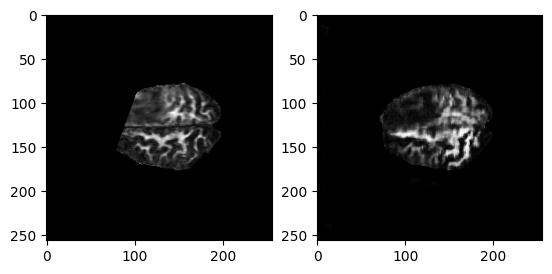

In [18]:
from metrics import calculate_psnr, calculate_ssim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
for el1, el2 in zip(test[0].take(1), test[1].take(1)):
    plt.subplot(1,2,1)
    plt.imshow(tf.squeeze(el2, axis=0).numpy()[:,:,0], 'gray')
    plt.subplot(1,2,2)
    plt.imshow(tf.squeeze(gen_g(el1), axis=0).numpy()[:,:,0], 'gray')
    print(peak_signal_noise_ratio(tf.squeeze(gen_g(el1), axis=0).numpy()[:,:,0],
                                tf.squeeze(el2, axis=0).numpy()[:,:,0]))

In [26]:
!pip install skimage

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
